In [1]:
from functools import total_ordering
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from collections import defaultdict
import subprocess
import string
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# {'ϔ': 0, 's': 1, 'j': 2, '\x0c': 3, 'ß': 4, 'k': 5, 'ϋ': 6, '}': 7, '7': 8, ')': 9, 'l': 10, '>': 11, 
#  'ꮪ': 12, 'w': 13, 'v': 14, ']': 15, '1': 16, 'ⅳ': 17, '\x08': 18, '♦': 19, 'y': 20, '!': 21, '/': 22, 
#  '|': 23, '$': 24, ',': 25, 'ς': 26, '_': 27, 'z': 28, 'ꭲ': 29, '*': 30, 't': 31, '4': 32, '¹': 33, 
#  '[': 34, 'σ': 35, '∞': 36, 'b': 37, 'a': 38, '+': 39, '(': 40, '9': 41, '\u1680': 42, 'h': 43, '?': 44, 
#  'ı': 45, 'm': 46, '0': 47, '"': 48, 'ꮢ': 49, ':': 50, '໐': 51, 'u': 52, '6': 53, '%': 54, 'å': 55, 
#  'é': 56, '3': 57, '£': 58, 'p': 59, '#': 60, '.': 61, 'ü': 62, '8': 63, '@': 64, 'g': 65, 'i': 66, 
#  'x': 67, 'ዐ': 68, '０': 69, '5': 70, 'd': 71, '\\': 72, '2': 73, 'ſ': 74, 'ꮅ': 75, 'π': 76, 'e': 77, 
#  '-': 78, '<': 79, ';': 80, '=': 81, '&': 82, 'ﬁ': 83, '~': 84, '\ufeff': 85, 'r': 86, '\t': 87, 
#  '\x00': 88, 'ꮛ': 89, '€': 90, 'n': 91, '{': 92, '\n': 93, '`': 94, 'а': 95, ' ': 96, 'o': 97, 'c': 98, 
#  '^': 99, 'q': 100, "'": 101, 'f': 102}

specials = ['}', ')', '>', ']', '!', '/', '|', '$', ',', '_', '*', '?', '"', ':', '%', '@', '.', '#', '\\', '\t', '~', '&', '=', ';', '<', '-', '{', ' ', '^', "'"]

### All dummies are 0 one hot vectors in final sequences

In [3]:
# get max line in RFCs
onlyfiles = [join('../rfcs', f) for f in listdir('../rfcs') if isfile(join('../rfcs', f))]
length_max = []
for r in onlyfiles:
    with open(r,  encoding="utf8", errors='ignore') as rfh:
        lines = rfh.readlines()
        for l in lines:
            length_max.append([l, len(l)])
#ascending
length_max = sorted(length_max, key=lambda x:x[1], reverse=True)
# extract starting from the third element

In [4]:
def get_char_vocab():
    max_set = set()
    onlyfiles = [join('../rfcs', f) for f in listdir('../rfcs') if isfile(join('../rfcs', f))]
#     onlyfiles = ['../rfcs/mqtt.txt']
    for r in onlyfiles:
        with open(r,  encoding="utf8", errors='ignore') as rfh:
            lines = rfh.readlines()
            for l in lines:
                l = l.lower()
                l = set(l)
                max_set = max_set.union(l)
    return max_set

In [5]:
print(length_max[2][1])

82


In [6]:
# vocab is the set of all chars in RFCs (mentioned above)
# need to filter down to lowercase alphabets and chosen special characters
vocab = get_char_vocab()

In [7]:
allowed = list(string.ascii_lowercase) + [str(x) for x in range(10)] + specials + 'unk'

In [8]:
num_feat = len(allowed)+1

In [9]:
char_to_idx = {}
for i,e in enumerate(allowed):
    # allowed chars get an integer
    # all others get unknown (idx = len(allowed))
    char_to_idx[e] = i

In [10]:
_maxlen = length_max[2][1]
def create_samples(file):
    '''
    read each line, strip it, convert line to list of integers (indexes) usign char_to_idx
    join the resulting vector to master array
    return array
    '''
    data = []
    with open(file, 'r') as fh:
        lines = fh.readlines()
        for l in lines:
            if l=='\n':
                continue
            l = l.lower() 
            l = l.strip()
            cur_len = len(l)
            # convert to arr of integers
            curseq = []
            for c in l:
                try:
                    curseq.append(char_to_idx[c])
                except:
                    curseq.append(len(allowed))
            # pad sequences shorter than _maxlen
            pad = _maxlen - cur_len
            for _ in range(pad):
                curseq.append(len(allowed))
            data.append(curseq)
    return np.array(data)

In [11]:
X_pos = create_samples('pos_seq.txt')
y_pos = np.ones((X_pos.shape[0],1))
X_neg = create_samples('neg_seq.txt')
y_neg = np.zeros((X_neg.shape[0],1))

In [12]:
X = np.concatenate((X_pos, X_neg), axis=0)
Y = np.concatenate((y_pos, y_neg), axis=0)

In [13]:
def int_to_one_hot(idx):
    res = np.zeros((1,num_feat))
    res[0][idx] = 1
    return res

### convert data to one hot (not during training like usual)

In [14]:
vector_len = len(allowed)+1 # should be 67 in this case, added 1 for unknown
big_mat = []
for sample in X:
    mat = []
    for idx in sample:
        cand = np.zeros((vector_len))
        cand[idx] = 1 #(1x67)
        mat.append(cand)
    big_mat.append(np.array(mat))
    
big_mat = np.array(big_mat)
print(big_mat.shape)

(3052, 82, 67)


In [15]:
print('data and labels shape:', big_mat.shape, Y.shape)

data and labels shape: (3052, 82, 67) (3052, 1)


## PyTorch data and Model training for line classification

In [16]:
import torch
import torch.nn as nn
# from models import lstm_model, classifier
from torch.nn import LSTM, Linear, ReLU, BatchNorm1d
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [17]:
input_size = big_mat.shape[2]
batch_size = 64
hidden_size = 128
num_layers = 2
device = 'cuda'
epochs = 1200
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf

### big mat size: m,Tx,s (batch_size, timesteps, feat) : (16, 82, 67)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(big_mat, Y, test_size=0.33, random_state=42)
print('train sequences: ', X_train.shape[0])

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)) 
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=batch_size, 
                                                    shuffle=True)
            
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                    batch_size=batch_size, 
                                                    shuffle=False)

train sequences:  2044


In [18]:
class lstm_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True, drop_prob=0.5):
        super(lstm_model, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=num_layers, 
                        batch_first=batch_first, 
                        dropout=drop_prob)
        self.dense = Linear(hidden_size, 1)

    def forward(self, x):
        # hidden and cell state default to 0
        outputs, (ht, ct) = self.rnn(x)
#         print(outputs.size())
        out = outputs[:,-1,:]
#         print('out:', out.size())
        out = self.dense(out)
        return out

In [68]:
lstm_model = lstm_model(input_size, hidden_size, num_layers).to(device)
lr = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

In [21]:
def plot_current_loss_profile(train_loss_list, val_loss_list):
    plt.plot(range(len(train_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label='val')
    plt.legend(loc='upper right')
    plt.show()

[EPOCHS:0] epoch_loss:0.6914470717310905, val loss:0.6891188770532608
[EPOCHS:1] epoch_loss:0.6534771658480167, val loss:0.35432707518339157
[EPOCHS:2] epoch_loss:0.6320773726329207, val loss:0.6762362644076347
[EPOCHS:3] epoch_loss:0.6703439094126225, val loss:0.6764510422945023
[EPOCHS:4] epoch_loss:0.6716925483196974, val loss:0.6778993457555771
[EPOCHS:5] epoch_loss:0.6716752238571644, val loss:0.6782410740852356
[EPOCHS:6] epoch_loss:0.6721939314156771, val loss:0.6780778020620346
[EPOCHS:7] epoch_loss:0.6727995909750462, val loss:0.6783568970859051
[EPOCHS:8] epoch_loss:0.6727890931069851, val loss:0.6795032620429993
[EPOCHS:9] epoch_loss:0.6734068747609854, val loss:0.6795383878052235
[EPOCHS:10] epoch_loss:0.6740387938916683, val loss:0.6795334592461586
[EPOCHS:11] epoch_loss:0.6731088813394308, val loss:0.6802646927535534
[EPOCHS:12] epoch_loss:0.6739834602922201, val loss:0.6799376308917999
[EPOCHS:13] epoch_loss:0.6738810110837221, val loss:0.6799417957663536
[EPOCHS:14] epo

[EPOCHS:116] epoch_loss:0.6813376806676388, val loss:0.6803455613553524
[EPOCHS:117] epoch_loss:0.6813203301280737, val loss:0.6803971603512764
[EPOCHS:118] epoch_loss:0.6812869813293219, val loss:0.6803859248757362
[EPOCHS:119] epoch_loss:0.6813574712723494, val loss:0.6803572364151478
[EPOCHS:120] epoch_loss:0.6813243366777897, val loss:0.68039321154356
[EPOCHS:121] epoch_loss:0.6814332026988268, val loss:0.6804263442754745
[EPOCHS:122] epoch_loss:0.6812790092080832, val loss:0.6803534962236881
[EPOCHS:123] epoch_loss:0.6813755873590708, val loss:0.6803562268614769
[EPOCHS:124] epoch_loss:0.6812998801469803, val loss:0.6803967654705048
[EPOCHS:125] epoch_loss:0.6813191249966621, val loss:0.6803973764181137
[EPOCHS:126] epoch_loss:0.6813450958579779, val loss:0.6804376430809498
[EPOCHS:127] epoch_loss:0.6813645008951426, val loss:0.6804148182272911
[EPOCHS:128] epoch_loss:0.6812719907611609, val loss:0.6803780794143677
[EPOCHS:129] epoch_loss:0.6814447976648808, val loss:0.68031278625

[EPOCHS:231] epoch_loss:0.5402059927582741, val loss:0.5307634882628918
[EPOCHS:232] epoch_loss:0.5408577946946025, val loss:0.5310568492859602
[EPOCHS:233] epoch_loss:0.5412672841921449, val loss:0.5311778206378222
[EPOCHS:234] epoch_loss:0.5418727612122893, val loss:0.5309900883585215
[EPOCHS:235] epoch_loss:0.5423352457582951, val loss:0.5312915053218603
[EPOCHS:236] epoch_loss:0.5416268780827522, val loss:0.5314296241849661
[EPOCHS:237] epoch_loss:0.5408932762220502, val loss:0.5305289328098297
[EPOCHS:238] epoch_loss:0.5403086086735129, val loss:0.5305546037852764
[EPOCHS:239] epoch_loss:0.5399609617888927, val loss:0.5298042427748442
[EPOCHS:240] epoch_loss:0.5388547386974096, val loss:0.5305147431790829
[EPOCHS:241] epoch_loss:0.5395907154306769, val loss:0.529726492241025
[EPOCHS:242] epoch_loss:0.5372401513159275, val loss:0.527231203392148
[EPOCHS:243] epoch_loss:0.5398271065205336, val loss:0.5265074782073498
[EPOCHS:244] epoch_loss:0.537809413857758, val loss:0.526012808084

[EPOCHS:343] epoch_loss:0.09896827227203175, val loss:0.09315119730308652
[EPOCHS:344] epoch_loss:0.09572285186732188, val loss:0.08808281109668314
[EPOCHS:345] epoch_loss:0.10087592829950154, val loss:0.09368994063697755
[EPOCHS:346] epoch_loss:0.09280916687566787, val loss:0.09002815140411258
[EPOCHS:347] epoch_loss:0.09579284337814897, val loss:0.09389744605869055
[EPOCHS:348] epoch_loss:0.0930152113432996, val loss:0.08582858461886644
[EPOCHS:349] epoch_loss:0.10156618396285921, val loss:0.1135524082928896
[EPOCHS:350] epoch_loss:0.09328133857343346, val loss:0.08314816909842193
[EPOCHS:351] epoch_loss:0.09066308836918324, val loss:0.08617627224884927
[EPOCHS:352] epoch_loss:0.08425272261956707, val loss:0.08647732110694051
[EPOCHS:353] epoch_loss:0.09908639712375589, val loss:0.08573477528989315
[EPOCHS:354] epoch_loss:0.08286652807146311, val loss:0.09005807572975755
[EPOCHS:355] epoch_loss:0.08893239224562421, val loss:0.08698897226713598
[EPOCHS:356] epoch_loss:0.07922009215690

[EPOCHS:455] epoch_loss:0.09623223246308044, val loss:0.1168345995247364
[EPOCHS:456] epoch_loss:0.07262845797231421, val loss:0.10950825153850019
[EPOCHS:457] epoch_loss:0.12501952989259735, val loss:0.13805254525505006
[EPOCHS:458] epoch_loss:0.11145312199369073, val loss:0.1409576756414026
[EPOCHS:459] epoch_loss:0.08886812051059678, val loss:0.14454254182055593
[EPOCHS:460] epoch_loss:0.06676704966230318, val loss:0.14395001414231956
[EPOCHS:461] epoch_loss:0.061745362501824275, val loss:0.13949273090111092
[EPOCHS:462] epoch_loss:0.06536996201612055, val loss:0.13553056120872498
[EPOCHS:463] epoch_loss:0.06135872798040509, val loss:0.13353873242158443
[EPOCHS:464] epoch_loss:0.05998513280064799, val loss:0.14152496500173584
[EPOCHS:465] epoch_loss:0.055941675062058493, val loss:0.14761221199296415
[EPOCHS:466] epoch_loss:0.059387470450019464, val loss:0.1472965101711452
[EPOCHS:467] epoch_loss:0.05556729677482508, val loss:0.14562522969208658
[EPOCHS:468] epoch_loss:0.056818557466

[EPOCHS:566] epoch_loss:0.02923154813470319, val loss:0.1538787557510659
[EPOCHS:567] epoch_loss:0.03170679530376219, val loss:0.168763652240159
[EPOCHS:568] epoch_loss:0.03471757959778188, val loss:0.15726524038473144
[EPOCHS:569] epoch_loss:0.03216182430332992, val loss:0.15229486106545664
[EPOCHS:570] epoch_loss:0.02984474906406831, val loss:0.15511949284700677
[EPOCHS:571] epoch_loss:0.029739825826254673, val loss:0.15545663781813346
[EPOCHS:572] epoch_loss:0.028706485296424944, val loss:0.15630562795558944
[EPOCHS:573] epoch_loss:0.02882414653140586, val loss:0.1600891116540879
[EPOCHS:574] epoch_loss:0.028413250620360486, val loss:0.15968416616669856
[EPOCHS:575] epoch_loss:0.030537773287505843, val loss:0.1587210547295399
[EPOCHS:576] epoch_loss:0.027834093118144665, val loss:0.16253198345657438
[EPOCHS:577] epoch_loss:0.02769711334258318, val loss:0.1637571329192724
[EPOCHS:578] epoch_loss:0.0264840506206383, val loss:0.16564831812866032
[EPOCHS:579] epoch_loss:0.02659806002338

[EPOCHS:677] epoch_loss:0.02279873647057684, val loss:0.14041876123519614
[EPOCHS:678] epoch_loss:0.024942422085587168, val loss:0.15679058301611803
[EPOCHS:679] epoch_loss:0.019179982540663332, val loss:0.1505443435453344
[EPOCHS:680] epoch_loss:0.017957830168597866, val loss:0.1707568792044185
[EPOCHS:681] epoch_loss:0.017981989971303847, val loss:0.1534948043699842
[EPOCHS:682] epoch_loss:0.015750102364108898, val loss:0.1576663674932206
[EPOCHS:683] epoch_loss:0.012520858253992628, val loss:0.1632256248703925
[EPOCHS:684] epoch_loss:0.01191570579976542, val loss:0.16398290536017157
[EPOCHS:685] epoch_loss:0.011340136734361295, val loss:0.17079601619479945
[EPOCHS:686] epoch_loss:0.010885620067710988, val loss:0.18421027665317524
[EPOCHS:687] epoch_loss:0.013142718007657095, val loss:0.17665155650684028
[EPOCHS:688] epoch_loss:0.013123471386279562, val loss:0.1579788189555984
[EPOCHS:689] epoch_loss:0.01705686206878454, val loss:0.17660903139039874
[EPOCHS:690] epoch_loss:0.01081655

[EPOCHS:788] epoch_loss:0.013031912606720653, val loss:0.17319913528626785
[EPOCHS:789] epoch_loss:0.00840676836514831, val loss:0.17368636550691008
[EPOCHS:790] epoch_loss:0.0063568293990101665, val loss:0.17901303134021873
[EPOCHS:791] epoch_loss:0.0065832516565933474, val loss:0.1741926437730399
[EPOCHS:792] epoch_loss:0.007208220402389998, val loss:0.1656995638513763
[EPOCHS:793] epoch_loss:0.009138001044448174, val loss:0.19461096952181833
[EPOCHS:794] epoch_loss:0.008781232929777616, val loss:0.19208972622072906
[EPOCHS:795] epoch_loss:0.020848492445793454, val loss:0.19507813081145287
[EPOCHS:796] epoch_loss:0.01468980177605772, val loss:0.19124757753525046
[EPOCHS:797] epoch_loss:0.014899153884016414, val loss:0.17157735946966568
[EPOCHS:798] epoch_loss:0.007145364475263705, val loss:0.17790798420537612
[EPOCHS:799] epoch_loss:0.007086692047550969, val loss:0.18718378635458066
[EPOCHS:800] epoch_loss:0.006596934125354892, val loss:0.20006128703380455
[EPOCHS:801] epoch_loss:0.0

[EPOCHS:898] epoch_loss:0.004559536517717788, val loss:0.1604435830249713
[EPOCHS:899] epoch_loss:0.004683478235165239, val loss:0.15969416568896122
[EPOCHS:900] epoch_loss:0.004485287043962671, val loss:0.16092812287843117
[EPOCHS:901] epoch_loss:0.0044265400169933855, val loss:0.16185589748101847
[EPOCHS:902] epoch_loss:0.004365056036249371, val loss:0.16325799576316058
[EPOCHS:903] epoch_loss:0.004351509280240862, val loss:0.16563066549588257
[EPOCHS:904] epoch_loss:0.004667176589009614, val loss:0.16653233749093488
[EPOCHS:905] epoch_loss:0.004095610700005636, val loss:0.1689122723582841
[EPOCHS:906] epoch_loss:0.00454750174367291, val loss:0.1674112850223537
[EPOCHS:907] epoch_loss:0.006130785082632428, val loss:0.17548954397625494
[EPOCHS:908] epoch_loss:0.006222395885060905, val loss:0.17168386364573962
[EPOCHS:909] epoch_loss:0.004919495823287434, val loss:0.16299469938803668
[EPOCHS:910] epoch_loss:0.004306644943312676, val loss:0.16702409421850462
[EPOCHS:911] epoch_loss:0.00

[EPOCHS:1008] epoch_loss:0.004091888914729225, val loss:0.22082850873573534
[EPOCHS:1009] epoch_loss:0.00431261876254041, val loss:0.2210499901229923
[EPOCHS:1010] epoch_loss:0.004273731719820262, val loss:0.22108940091493423
[EPOCHS:1011] epoch_loss:0.003930336629281328, val loss:0.22264446927715653
[EPOCHS:1012] epoch_loss:0.0042088670248574545, val loss:0.2232440581865376
[EPOCHS:1013] epoch_loss:0.004029834360196105, val loss:0.22207386522592287
[EPOCHS:1014] epoch_loss:0.004107351606208454, val loss:0.22203380255206184
[EPOCHS:1015] epoch_loss:0.003951105651395892, val loss:0.22201327175071128
[EPOCHS:1016] epoch_loss:0.0041708980997725575, val loss:0.2231047231350658
[EPOCHS:1017] epoch_loss:0.004242263887036302, val loss:0.2239220989149544
[EPOCHS:1018] epoch_loss:0.004164153103332069, val loss:0.22442221175896293
[EPOCHS:1019] epoch_loss:0.004365259398895205, val loss:0.22729510361097027
[EPOCHS:1020] epoch_loss:0.00570864207709576, val loss:0.22945381804561293
[EPOCHS:1021] ep

[EPOCHS:1117] epoch_loss:0.0064246297720274015, val loss:0.17599253451544428
[EPOCHS:1118] epoch_loss:0.006506560464799804, val loss:0.18146223336225376
[EPOCHS:1119] epoch_loss:0.0067868530220493994, val loss:0.18072873766504927
[EPOCHS:1120] epoch_loss:0.006627089417747811, val loss:0.16128108486009296
[EPOCHS:1121] epoch_loss:0.007703868383941881, val loss:0.16178589211813232
[EPOCHS:1122] epoch_loss:0.00525237377337362, val loss:0.15734778759997425
[EPOCHS:1123] epoch_loss:0.004598752242827686, val loss:0.16350275366494316
[EPOCHS:1124] epoch_loss:0.0044333615649065905, val loss:0.16676578537044406
[EPOCHS:1125] epoch_loss:0.004035670765006216, val loss:0.17009402500752913
[EPOCHS:1126] epoch_loss:0.004607666721199166, val loss:0.17370026981279807
[EPOCHS:1127] epoch_loss:0.004904781181949147, val loss:0.17536240045501472
[EPOCHS:1128] epoch_loss:0.004494903969089137, val loss:0.17755495438177604
[EPOCHS:1129] epoch_loss:0.009222508010452657, val loss:0.19106387115607504
[EPOCHS:11

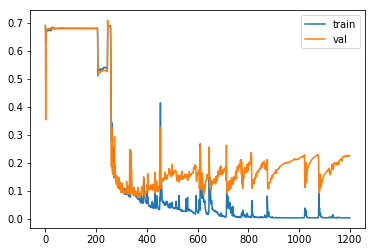

In [22]:
lstm_model.train()
train_loss_total = []
val_loss_total = []
for e in range(epochs):
    running_epoch_loss = 0
    for data, target in train_loader:
        counter+=1
        data, target = data.to(device), target.to(device)
        lstm_model.zero_grad()
        output = lstm_model(data)
#         print(output.size(), target.size())
        loss = criterion(output, target)
        running_epoch_loss+=loss.item()
        loss.backward()
        # nn.utils.clip_grad_norm_(lstm_model.parameters(), clip) # need this??
        optimizer.step()
    
    lstm_model.eval()
    running_val_loss = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = lstm_model(data)
        val_loss = criterion(output, target)
        running_val_loss+=val_loss.item()
    train_loss_total.append(running_epoch_loss/len(train_loader))
    val_loss_total.append(running_val_loss/len(test_loader))
    lstm_model.train()
    print('[EPOCHS:{}] epoch_loss:{}, val loss:{}'.format(e, train_loss_total[-1], val_loss_total[-1]))
plot_current_loss_profile(train_loss_total, val_loss_total)
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

## Initial tests

In [19]:
lstm_model = lstm_model(input_size, hidden_size, num_layers).to(device)
lstm_model.load_state_dict(torch.load('lstm_model.pth'))

<All keys matched successfully>

In [44]:
# testdata = create_samples('../rfcs/rfc2616.txt')
testdata = create_samples('test_samples/test_pos_mqtt.txt')
testlabels = np.ones((testdata.shape[0],1))
print(testdata.shape)
print(testlabels.shape)

vector_len = len(allowed)+1 # should be 67 in this case, added 1 for unknown
_mat = []
for sample in testdata:
    m = []
    for idx in sample:
        cand = np.zeros((vector_len))
        cand[idx] = 1 #(1x67)
        m.append(cand)
    _mat.append(np.array(m))
    
_mat = np.array(_mat)
print(_mat.shape)

(143, 82)
(143, 1)
(143, 82, 67)


In [45]:
td = TensorDataset(torch.Tensor(_mat), torch.Tensor(testlabels)) 
tldr = torch.utils.data.DataLoader(dataset=td, batch_size=1, shuffle=False)
def threshold_prob(y):
    if y>0.5: return 1
    return 0
def calc_acc(y_pred, label):
    return (len(y_pred)-len(y_pred[y_pred!=label]))/len(y_pred)

In [46]:
lstm_model.eval()
y_pred = []
i=0
for data, target in tldr:
    data, target = data.to(device), target.to(device)
    output = nn.Sigmoid()(lstm_model(data))
#     y_pred.append([threshold_prob(output.item()), i])
    y_pred.append(threshold_prob(output.item()))
    i+=1

In [47]:
label = 1
print(calc_acc(np.array(y_pred), label))

0.972027972027972


In [48]:
for idx,j in enumerate(list(y_pred)):
    print(idx+1,j)

1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 0
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 0
132 0
133 0
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1


### Observations from the current model

1. learning to extract sparse lines. "Figure 2" will be extracted. "figure 2: {one line of text}" wont be extracted
<br>
2. false negatives and false positives are a problem that can be partially solved with post processing
<br>
3. model has the most problem extracting table headers
<br>
4. extracting structs, while symbol based extraction missed it (RFC7530)
<br> 
e.g. : "TCP A                      TCP B" at the start of the table (RFC 793), line 2484. Indistinguishable from a plain text line: solved either with post processing/or sequence based models

### Ideas

In [85]:
###### : Improvement: while training/validating/testing, if a line is 
#        all alphanumeric and is less than 25 (hyperparameter) chars, then 
#        either remove it, or make it a part of previous line

# run an rfc through the model line by line. Note the indexes of lines that are accepted (dont while creating testdata)
# combine the lines with the rule:
    # for each line  and its index
        # if the line was accpeted, and index of this line is within 5 indices of the previous
            # join the two in a single artifact
        # else
            # start creating a new artifact

# Evaluation strat [not raw RFCs]
    # 20 pre decided RFCs, sample artif. randomly
    # random sampling (RFCs and Artifact) and pred acc   

# AI 2:
# Pruning of test data - remove contents and everything above it

# AI xx??:
# pre-processing : eliminate single line artifacts

# post-processing:  Join lines extracted close by [if line above is 1
# and line below is 1, this line is also probably 1]

# AI 3: Raw RFCs
# n-way classifier for line samples that include context (10 lines above and below)
# fix seq : max(len(all_artifacts))


# compare two things: with/without pre processing

### steps
<br>
0. Collect n-way data
<br>
1. implement context based model, eval model : n-way classifier
<br>
2. implement pre/post processing and n-way classifier